# Modifying Conv1 layer of CIFAR10 Network using Pruning, Quantization and Huffman Encoding methods of the Deep Compression paper

## Load the pretrained model, solvers, and look at the shape of the model

In [1]:
!sudo ldconfig /usr/local/cuda/lib64


from pylab import *
import os
%matplotlib inline
caffe_root = '/home/super/ISHA/Deep_Learning/Caffe/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
 
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
 
GPU_ID = 1 # Switch between 0 and 1 depending on the GPU you want to use.
caffe.set_mode_gpu()
caffe.set_device(1)
os.chdir(caffe_root)
 
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/cifar10_full_solver.prototxt')
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
 
 
[(k, v[0].data.shape) for k, v in solver.net.params.items()]
 

/sbin/ldconfig.real: /usr/local/cuda/lib64/libcudnn.so.5 is not a symbolic link

/sbin/ldconfig.real: /usr/lib/x86_64-linux-gnu/libcudnn.so.5 is not a symbolic link

/sbin/ldconfig.real: /usr/lib/nvidia-375/libEGL.so.1 is not a symbolic link

/sbin/ldconfig.real: /usr/lib32/nvidia-375/libEGL.so.1 is not a symbolic link



[('conv1', (32, 3, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (10, 1024))]

### Look at the distribution of the weights. Sort the weights by the absolute magnitude, with the most important weight being the one with the highest magnitude. Notice that most weights are concentrated near the origin, and the distribution looks like a Guassian centred at 0.

('stats for layer', 'conv1')
('max, min and mean value  of original data are ', 0.38542399, -0.36021158, -0.00019509663)
('max, min and mean value  of absolute value of original data  are ', 0.38542399, 5.1449009e-05, 0.067123264)


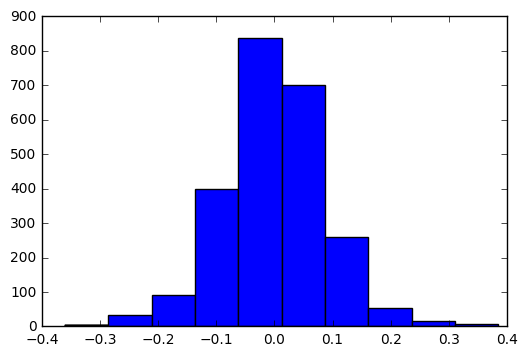

('number of non zero elements in original data are: ', 2400)
the indices of the largest 10 weights and their values are
(8, 0, 2, 2) 0.385424
(3, 1, 2, 2) -0.360212
(11, 0, 1, 2) 0.33931
(8, 2, 2, 2) 0.338287
(31, 1, 1, 2) -0.334987
(8, 1, 2, 2) 0.331826
(3, 0, 2, 2) -0.32304
(11, 2, 1, 2) 0.32127
(31, 1, 2, 1) 0.320731
(3, 2, 2, 2) -0.308671


In [2]:
def layer_stats(solver,layername):
    print('stats for layer',layername)
    original_data=np.copy(solver.net.params[layername][0].data[:])
    absolute_orig_data=np.abs(original_data)
    print('max, min and mean value  of original data are ',np.max(original_data),np.min(original_data),np.mean(original_data))
    print('max, min and mean value  of absolute value of original data  are ',np.max(absolute_orig_data),np.min(absolute_orig_data),np.mean(absolute_orig_data))
    plt.hist(original_data.flatten(),bins=10)
    plt.show()
    
    ## Sort the weigh indices according to magnitude, in descending order
    train_abs=np.copy(absolute_orig_data)
    print('number of non zero elements in original data are: ',np.count_nonzero(train_abs))

    flat_sort_rev_trainwt=[]

    #code to rank weights
    for index, x in np.ndenumerate(train_abs):
      flat_sort_rev_trainwt.append([index,x])


    flat_sort_rev_trainwt.sort(key=lambda x: x[1],reverse=True)

    print('the indices of the largest 10 weights and their values are')
    trainwt_bottom=[]
    for i in range(10): 
      trainwt_bottom.append(flat_sort_rev_trainwt[i][0][:])
      print trainwt_bottom[-1],original_data[trainwt_bottom[-1]]
    
    return flat_sort_rev_trainwt

flat_sort_rev_trainwt= layer_stats(solver,'conv1')

## PRUNING SETUP:

#### Create a mask to mask out the weights that you want to prune out

In [3]:
def create_mask(solver,layername,num_elements_retained,flat_sort_rev_trainwt):
    mask=np.zeros(np.shape(solver.net.params[layername][0].data[:]))
    total=len(flat_sort_rev_trainwt)

    for i in range(num_elements_retained):
          mask[flat_sort_rev_trainwt[i][0]]=1


    print 'total number of elements in the layer = ' + str(total)
    print 'number of weights retained = ' + str(num_elements_retained)
    print 'non zero elements and sum of mask='+str(sum(mask))
    print 'zeroed out elements=' + str(total-sum(mask))
    
    return mask
    
mask=create_mask(solver,'conv1',100,flat_sort_rev_trainwt)

total number of elements in the layer = 2400
number of weights retained = 100
non zero elements and sum of mask=100.0
zeroed out elements=2300.0


#### Create the training and testing loops

In [4]:
#training loop
def training_loop_pruning(solver,mask,layername,niter=60000):
  print('starting training')
 # niter = 60000
  test_interval = 1000
  train_loss = zeros(niter)
  test_acc = zeros(int(np.ceil(niter / test_interval)))
  output = zeros((niter, 8, 10))

# the main solver loop
  for it in range(niter):
      solver.step(1)  # SGD by Caffe
    
    # store the train loss
      train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at ip1 to avoid loading new data)
      solver.test_nets[0].forward(start='conv1')
      output[it] = solver.test_nets[0].blobs['ip1'].data[:8]
      solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:] * mask
        
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
      if it % test_interval == 0:
       # print 'Iteration', it, 'testing...'
       # print('nonzero in ip1 num are:',len(np.nonzero(solver.test_nets[0].params['ip1'][0].data[:])[0]))
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
  return test_acc[-1]

    

In [20]:
def train_with_mask(elements_to_retain,flat_sort_rev_trainwt,solver,layername,niter=60000):
  solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
  print('solver loaded')


  mask=np.zeros(np.shape(solver.net.params[layername][0].data[:]))
  total=len(flat_sort_rev_trainwt)
  for i in range(elements_to_retain):
    mask[flat_sort_rev_trainwt[i][0]]=1


  print 'total number of elements = '  + str(total)
  print 'thresh_percent, number of weights retained = ' + str(elements_to_retain)
  print 'non zero elements and sum of mask='+str(sum(mask))
  print 'zeroed out elements=' + str(total-sum(mask))

 
  solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:] * mask
  print('starting training for bot_thresh=',elements_to_retain)
  test_acc=training_loop_pruning(solver,mask,layername,niter)
  print('testing accuracy is: ',test_acc)
  return test_acc

In [21]:
 
solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference.caffemodel.h5')
#solver.test_nets[0].params['conv1'][0].data[:]=np.copy(new100)

correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print(correct/1e4)

0.8183


#### decide pruning thresholds (number of weights you want to retain), and retrain keeping only those elemts active via a mask. Decide upon the final threshold, and save the trained model weights.

In [ ]:
accuracy=[]
retained=[10,20,40,60,80,100]
for retain in retained:
    print('running case',retain)
    accuracy.append(train_with_mask(retain,flat_sort_rev_trainwt,solver,'conv1',niter=60000))
    
print(accuracy)

('running case', 10)
solver loaded
total number of elements = 2400
thresh_percent, number of weights retained = 10
non zero elements and sum of mask=10.0
zeroed out elements=2390.0
('starting training for bot_thresh=', 10)
starting training


In [14]:
#retest pruned solver after loading the relevant model.
solver.net.copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference100.caffemodel.h5')
solver.test_nets[0].copy_from('/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference100.caffemodel.h5')
original_data100=np.copy(solver.net.params['conv1'][0].data[:])

print('number of nonzero weights are ',len(np.nonzero(solver.net.params['conv1'][0].data[:])[0]))

correct = 0
for test_it in range(100):
    solver.test_nets[0].forward()
    correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
print('accuracy is ',correct/1e4)

('number of nonzero weights are ', 1350)
('accuracy is ', 0.73899999999999999)


## QUANTIZATION SETUP


#### Save the pruned  layer weights and create the mask 

In [15]:
original_data100=np.copy(solver.net.params['conv1'][0].data[:])
mask=np.zeros(np.shape(solver.net.params['conv1'][0].data[:]))
for i in range(100):
  mask[flat_sort_rev_trainwt[i][0]]=1

In [16]:
# quantizer weights according to codebok and code
def quantize_weights(solver,codebook,code,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    weight_conv1_flattened=original_data.flatten()
    nz_idx=np.nonzero(weight_conv1_flattened)
    conv1_flat_changed=np.zeros(weight_conv1_flattened.shape)
    for idx,nzidx in enumerate(nz_idx[0]):
        conv1_flat_changed[nzidx]=codebook[code[idx]]
    conv1_changed=conv1_flat_changed.reshape(original_data.shape)
    return conv1_changed


#quantize the backward gradients
def quantize_grads(solver,code,codebook,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    weight_conv1_flattened=original_data.flatten()
    nz_idx=np.nonzero(weight_conv1_flattened)
    gradients=solver.net.params[layername][0].diff
    gradients_codebook=np.zeros((codebook.shape))
    grads_flatten=gradients.flatten()
    final_grads=[]
    [final_grads.append(grads_flatten[nzidx]) for nzidx in nz_idx[0]]
    for idx,grad in enumerate(final_grads):
        gradients_codebook[code[idx]]+=grad
    return gradients_codebook


#update the codebook with the cumulative gradient, sort of like a custom solver.step(1) for the codebook
def update_codebook(codebook,gradients_codebook,learning_rate,velocity,momentum):
    velocity=np.multiply(momentum,velocity)-np.multiply(learning_rate,gradients_codebook)
    codebook+=velocity
    return codebook,velocity
        
#wrap forward, backward and update step into 1 training step       
def quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,layername):
    solver.step(1)
    solver.net.params[layername][0].data[:]= solver.net.params[layername][0].data[:]*mask
    gradients_codebook=quantize_grads(solver,code,codebook,'conv1')
    codebook,velocity=update_codebook(codebook,gradients_codebook,learning_rate,velocity,momentum)
    quantized_weights=quantize_weights(solver,codebook,code,'conv1')
    solver.net.params[layername][0].data[:]=np.copy(quantized_weights)
    for k, v in solver.net.params.items():
        solver.test_nets[0].params[k][0].data[:]= np.copy(v[0].data)

    
#generate codebook from kmeans clustering trained weights
#using uniform cenroid initialization as that gives best results
def cluster_trained_weights(solver,numClusters,layername):
    original_data=np.copy(solver.net.params[layername][0].data[:])
    nz_idx=np.nonzero(original_data)
    nz_data=original_data[nz_idx]
    X=nz_data.flatten()
    X=X.reshape(-1,1)
    #X=whiten(X)
    InitC=np.linspace(X.min(),X.max(),num=numClusters)
    codebook, codeX=kmeans2(X, InitC.reshape(-1,1), minit='matrix')
    #codebook, codeX=kmeans2(X, numClusters, minit='points')
    #codeX,dist=vq(X,codebook)
    #print(code.min(),code.max())
    edges_hist=[x for x in range(numClusters+1)]
    frq, edges = np.histogram(codeX,edges_hist)
    fig, ax = plt.subplots()
    ax.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge")
    plt.show()
    return codeX,codebook



#training loop
def training_loop(solver,niter,codebook,code,mask,learning_rate,velocity,momentum,layername):
  print('starting training')
  test_interval=1000
  train_loss = zeros(niter)
  test_acc = zeros(int(np.ceil(niter / test_interval)))
  output = zeros((niter, 8, 10))


# the main solver loop
  for it in range(niter):
    #if it>niter/2: learning_rate=learning_rate/8 #uncomment this if you need to reduce learning rate
            
    # solver.step(1)
      quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,'conv1')  # custom SGD step for quantization
    
    # store the train loss
      train_loss[it] = solver.net.blobs['loss'].data
    # (start the forward pass at conv1 to avoid loading new data)
      solver.test_nets[0].forward(start='conv1')
      output[it] = solver.test_nets[0].blobs['ip1'].data[:8]
      solver.net.params[layername][0].data[:] = solver.net.params[layername][0].data[:]  * mask
    # run a full test every so often
      if it % test_interval == 0:
       # print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip1'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4
        print('accuracy for this iteration is',correct/1e4)
    
  _, ax1 = subplots()
  ax2 = ax1.twinx()
  ax1.plot(arange(niter), train_loss)
  ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
  ax1.set_xlabel('iteration')
  ax1.set_ylabel('train loss')
  ax2.set_ylabel('test accuracy')
  ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
        
  return test_acc[-1]


def refresh_solver(solver,data,reference,layername):
    solver.net.copy_from(reference)
    solver.net.params[layername][0].data[:]=np.copy(data)

def top_level_training(solver,clusters,mask,data,reference,layername,learning_rate=0.0001,momentum=0.9,niter=60000):
    refresh_solver(solver,data,reference,'conv1')
    print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
    code,codebook = cluster_trained_weights(solver,clusters,layername)
    print('shape of code and codebook is ',code.shape,codebook)
    solver.net.params[layername][0].data[:]=np.copy(quantize_weights(solver,codebook,code,layername))
    print('toplevel shape nonzero is',len(np.nonzero(solver.net.params[layername][0].data[:])[0]))
    velocity=np.zeros(codebook.shape) #TODO: possible bug. Check how velocity is initialized
    quantized_training_step(solver,codebook,code,mask,learning_rate,velocity,momentum,layername)
    return training_loop(solver,niter,codebook,code,mask,learning_rate,velocity,momentum,layername)

    

    

In [17]:
    
data100=original_data100
reference100='/home/super/ISHA/Deep_Learning/16Nov/neuron_wise_exhaustive/reference100.caffemodel.h5'
mask100=np.zeros(np.shape(solver.net.params['conv1'][0].data[:]))
for i in range(100):
  mask100[flat_sort_rev_trainwt[i][0]]=1
    
print(len(np.nonzero(original_data100)[0]))


1350


('running for clusters', 2)
('toplevel shape nonzero is', 1350)


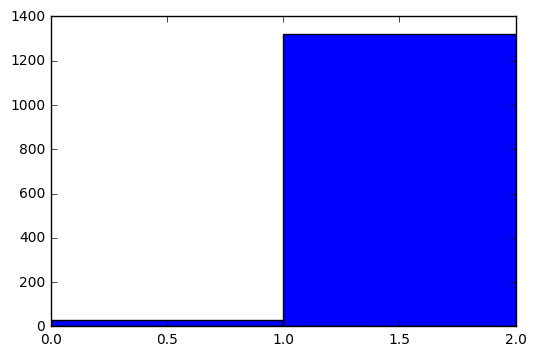

('shape of code and codebook is ', (1350,), array([[-0.43558228],
       [ 0.01160863]], dtype=float32))
('toplevel shape nonzero is', 1350)
starting training
('accuracy for this iteration is', 0.1145)
('accuracy for this iteration is', 0.41339999999999999)
('accuracy for this iteration is', 0.44979999999999998)
('accuracy for this iteration is', 0.47420000000000001)
('accuracy for this iteration is', 0.49419999999999997)
('accuracy for this iteration is', 0.5121)
('accuracy for this iteration is', 0.52400000000000002)
('accuracy for this iteration is', 0.53300000000000003)
('accuracy for this iteration is', 0.5423)
('accuracy for this iteration is', 0.55179999999999996)
('accuracy for this iteration is', 0.55769999999999997)
('accuracy for this iteration is', 0.5605)
('accuracy for this iteration is', 0.56520000000000004)
('accuracy for this iteration is', 0.57040000000000002)


KeyboardInterrupt: 

In [18]:
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2

numClusters=[2,4,8,16,32]
final_acc=[]
for nc in numClusters:
    print('running for clusters',nc)
    final_acc.append(top_level_training(solver,nc,mask100,data100,reference100,'conv1',niter=60000))
    print('final_acc')

In [ ]:
len(np.nonzero(solver.net.params['conv1'][0].data[:])[0])